# Optimized threshold for each output

This script creates an optimized threshold dictionary per output. 

It explores SHERPA studies specifically performed to find the optimal threshold for each output. The ***optimal threshold*** *is the most stringent threshold that allows the CausalNN achieving the minim validation loss (i.e., using two-sig-figures of the mse).*

In addition it plots the NNs' loss (performance) vs complexity (num. of trainable parameters).

## Packages, Modules & Definitions

In [1]:
import os, pickle, glob, yaml
import numpy    as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from pathlib import Path
import csv
from math import log10, floor
from sklearn    import preprocessing
from collections import Counter
from os.path import exists

In [2]:
def count_inputs(input_list_file):
    c = Counter()
    with open(input_list_file) as f:
        for line in f:
            input = line.strip()
            c[input] += 1
    return c['1']

def calc_parameters(inputs, outputs, nl, nodes):
    l_hidden = [nodes]*nl
    layers   = l_hidden + [outputs]
    parameters = 0
    for iL in range(len(layers)):
        if iL == 0: parameters += ( inputs * layers[iL] + layers[iL] )
        else: parameters += ( layers[iL-1] * layers[iL] + layers[iL] )
    return parameters

def round_sig(x, sig=2):
    return round(x, sig-int(floor(log10(abs(x))))-1)


## Options

In [3]:
SHE_alg    = 'GridSearch'
SHE_path   = f'./hyperparameter_tuning_{SHE_alg}_SHERPA/'
SHE_date   = '20220327_'
# SHE_date   = '20220327_f'
# SHE_date   = '20220327_phq-'
# SHE_date   = '20220327_tphystnd-'
sig        = 2
pdf        = True

In [4]:
thrsType = 'quantile' if pdf else 'spatially'
outPath = "./nn_config/"+thrsType+"_dicts/"
Path(outPath).mkdir(parents=True, exist_ok=True)
outFile = outPath+f"000_{thrsType}_thresholds.yml"

## SHERPA Studies

In [5]:
thresholds_dict = {}; thresholds_dict['thresholds_dict'] = {}
loss_complexity_dict = {}
loss       = {'absolute':[],'normalized':[]}
complexity = {'absolute':[],'normalized':[]}

SHE_studies = glob.glob(SHE_path+SHE_date+'*')

for i, study in enumerate(SHE_studies):
    print(f"Process study: {study}")
    output   = study.split('/')[-1].split('_')[-1]
    
    loss_complexity_dict[output] = {}
    loss_output = []; loss_sig_output = []; complexity_output = []
    
    file = open(f"{study}/results.csv")
    csvreader = csv.reader(file)
    
    header = next(csvreader)
    for row in csvreader:
        if 'COMPLETED' == row[1]:
            
            threshold = glob.glob(study+f"/{row[0]}/*/*")[0].split('/')[-1].split('-')[1][1:]
            input_list_file = glob.glob(study+f"/{row[0]}/*/*/*/*input_list.txt")[0]
            num_inputs      = count_inputs(input_list_file)        
            
            cpx = calc_parameters(num_inputs, 1, int(row[3]), int(row[4]))
            loss_complexity_dict[output][row[0]] = {
                 'threshold':threshold,
                'num_inputs':num_inputs,
                'num_layers':int(row[3]),
                 'num_nodes':int(row[4]),
                      'loss':float(row[-1]),
            'loss_round_sig':round_sig(float(row[-1]),sig),
                'complexity':cpx,
            }
            loss_output.append(float(row[-1]))
            loss_sig_output.append(round_sig(float(row[-1]),sig))
            complexity_output.append(cpx)

    # All output metrics
    loss['absolute'].append(loss_output); complexity['absolute'].append(complexity_output)
    complexity_norm = preprocessing.minmax_scale(complexity_output, feature_range=(0, 1), axis=0, copy=True)
    loss_norm       = preprocessing.minmax_scale(loss_output, feature_range=(0, 1), axis=0, copy=True)
    loss['normalized'].append(loss_norm); complexity['normalized'].append(complexity_norm)
    
    # Best case
    loss_output_min = np.min(loss_sig_output)
    best_trials     = [
        (id,i) for i,id in enumerate(loss_complexity_dict[output]) 
        if loss_complexity_dict[output][id]['loss_round_sig'] <= loss_output_min
    ]
    best_cpx   = [(loss_complexity_dict[output][i[0]]['complexity'],i[-1]) for i in best_trials]
    best_trial = best_trials[best_cpx.index(min(best_cpx))]
    
    # Best output case
    loss_complexity_dict[output]['best'] = {
              'trial':best_trial[0],
          'threshold':loss_complexity_dict[output][best_trial[0]]['threshold'],
         'num_inputs':loss_complexity_dict[output][best_trial[0]]['num_inputs'],
         'num_layers':loss_complexity_dict[output][best_trial[0]]['num_layers'],
          'num_nodes':loss_complexity_dict[output][best_trial[0]]['num_nodes'],
     'loss_round_sig':loss_complexity_dict[output][best_trial[0]]['loss_round_sig'],
          'loss_norm':loss_norm[best_trial[-1]],
         'complexity':loss_complexity_dict[output][best_trial[0]]['complexity'],
    'complexity_norm':complexity_norm[best_trial[-1]],
    }
    
    # Optmized threshold dictionary
    thresholds_dict['thresholds_dict'][output] = \
    float(loss_complexity_dict[output][best_trial[0]]['threshold'])
    
    file.close()
    
loss['absolute']         = np.array(loss['absolute']).flatten()
complexity['absolute']   = np.array(complexity['absolute']).flatten()
loss['normalized']       = np.array(loss['normalized']).flatten()
complexity['normalized'] = np.array(complexity['normalized']).flatten()


# Optmized threshold dictionary: Save?
if not exists(outFile):
    print(f"Create {outFile} dictionary.")
    with open(outFile, 'w') as outfile:
        yaml.dump(thresholds_dict, outfile, default_flow_style=False)
else:
    print(f"{outFile} dictionary exists.")

Process study: ./hyperparameter_tuning_GridSearch_SHERPA/20220327_flnt
Process study: ./hyperparameter_tuning_GridSearch_SHERPA/20220327_phq-820.86
Process study: ./hyperparameter_tuning_GridSearch_SHERPA/20220327_phq-445.99
Process study: ./hyperparameter_tuning_GridSearch_SHERPA/20220327_tphystnd-820.86
Process study: ./hyperparameter_tuning_GridSearch_SHERPA/20220327_flns
Process study: ./hyperparameter_tuning_GridSearch_SHERPA/20220327_tphystnd-197.91
Process study: ./hyperparameter_tuning_GridSearch_SHERPA/20220327_fsns
Process study: ./hyperparameter_tuning_GridSearch_SHERPA/20220327_prect
Process study: ./hyperparameter_tuning_GridSearch_SHERPA/20220327_phq-14.36
Process study: ./hyperparameter_tuning_GridSearch_SHERPA/20220327_fsnt
Process study: ./hyperparameter_tuning_GridSearch_SHERPA/20220327_tphystnd-445.99
Process study: ./hyperparameter_tuning_GridSearch_SHERPA/20220327_phq-197.91
Process study: ./hyperparameter_tuning_GridSearch_SHERPA/20220327_tphystnd-957.49
Process s

## Scatter plot

In [7]:
def loss_complexity_scatter_plot(
    loss_complexity_dict,
    loss,
    complexity,
    best=True,
    normalized=True,
    title='',
    lims=False,
    save=False,
    savenm=False,
    **kwargs
):
      
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    colors_dict = {
        32:'hotpink',64:'steelblue',128:'b',256:'indigo',512:'orange',1024:'chocolate',2048:'r',
    }
    markers_dict = {        
        1:'1',2:'2',3:'3',4:'>',5:'<',6:'^',7:'v',8:'+',9:'*',10:'.',
    }

    lims = lims if lims else 1
    
    # Normalization [0,1]? Note different outputs will have different loss.
    complexity = complexity['normalized'] if normalized else complexity['absolute']
    loss       =       loss['normalized'] if normalized else loss['absolute']
        
    # Scatter Plot
    ax.scatter(
        complexity,
        loss,
        color='grey',
    )

    # Best outputs case
    if best:
        for output in sorted(loss_complexity_dict):
            if normalized:
                complexity = loss_complexity_dict[output]['best']['complexity_norm'] 
                loss       = loss_complexity_dict[output]['best']['loss_norm']
            else:
                complexity = loss_complexity_dict[output]['best']['complexity'] 
                loss       = loss_complexity_dict[output]['best']['loss_round_sig']
            threshold  = loss_complexity_dict[output]['best']['threshold']
            num_inputs = loss_complexity_dict[output]['best']['num_inputs']
            color  = colors_dict[loss_complexity_dict[output]['best']['num_nodes']]
            marker = markers_dict[loss_complexity_dict[output]['best']['num_layers']]
            ax.scatter(
                complexity,
                loss,
                color=color,
                marker=marker,
                label=output+f" ({threshold}: {num_inputs})",
            )
    
    # Attributes
    if lims != False:
        ax.set_xlim(-.01, lims); ax.set_ylim(-.01, lims)
        ax.axline((-.01,lims) ,(lims, -.01), color='k', linestyle='--')
    else:
        ax.axline((0,lims) ,(lims, 0), color='k', linestyle='--')
    if normalized:
        ax.set_ylabel("Normalized loss (mse)"); ax.set_xlabel("Normalized Num. Parameters")
    else:
        ax.set_ylabel("Loss (mse)"); ax.set_xlabel("Parameters")
    ax.legend(ncol=3,fontsize='medium',bbox_to_anchor=(.5, -.5), loc='lower center')
    
    # Save fig
    fig.suptitle(title)
    if save is not False:
        Path(save).mkdir(parents=True, exist_ok=True)
        savenm = f'{statsnm}_single_level-{idx_lab}_nTime-{nTime}.png' if not savenm else savenm
        fig.savefig(f"{save}/{savenm}",dpi=1000.)
        print(f"{save}/{savenm}")
        
        # Legend: colors & markers
        fig_aux = plt.figure(figsize=(5, 5))
        for j, jKey in enumerate({**colors_dict, **markers_dict}):
            color = colors_dict[jKey] if jKey > 10 else 'k'
            marker=markers_dict[jKey] if jKey < 10 else 'o'
            lab   = 'nodes-'+str(jKey) if jKey > 10 else 'hl-'+str(jKey)
            plt.scatter(
                -100.,-100.,
                label=lab,
                alpha=.8,
                color=color,
                marker=marker,
                s=50,
            )
        plt.xlim(0, 10)
        plt.ylim(0, 10)
        plt.legend(ncol=3,fontsize='medium',loc='center',frameon=False)
        fig_aux.savefig(f"{save}/legend_aux.png",dpi=1000.)
            
    plt.show()

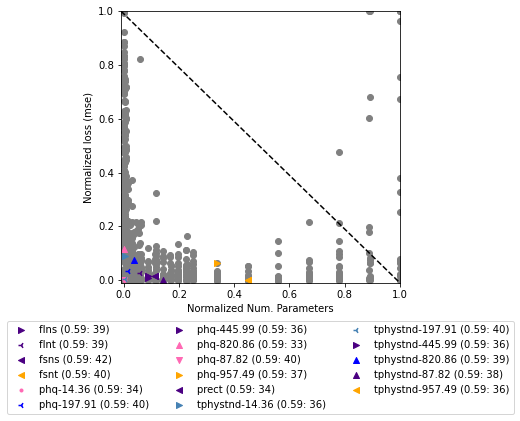

In [8]:
loss_complexity_scatter_plot(
    loss_complexity_dict,
    loss,
    complexity,
    best=True,
#     lims=.5,
#     save='./220411_loss_vs_complexity_plots', savenm=f"{SHE_path.split('/')[1]}_sig-{sig}.png",
)